In [18]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [19]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [20]:
%ls

dancing.jpg  gdrive/  lisa.jpg  picasso.jpg  sample_data/


In [21]:
!ls

dancing.jpg  gdrive  lisa.jpg  picasso.jpg  sample_data


In [22]:
imsize = 128  

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("picasso.jpg")# as well as here
content_img = image_loader("lisa.jpg")#измените путь на тот который у вас.

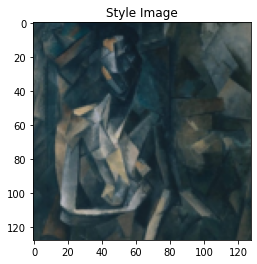

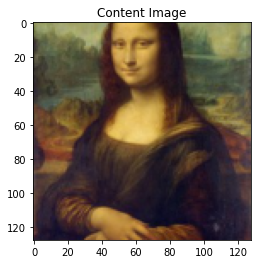

In [24]:
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# отрисовка

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [25]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [32]:
class Stogov():

  def __init__(self, style_img_0, content_img_0):
    imsize = 128  
    loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат
    style_img = image_loader(style_img_0)# as well as here
    content_img = image_loader(content_img_0)


  def gram_matrix(input):
    batch_size , h, w, f_map_num = input.size()  
    features = input.view(batch_size * h, w * f_map_num)  
    G = torch.mm(features, features.t()) 
    return G.div(batch_size * h * w * f_map_num)

  def forward_style(input):
    G = gram_matrix(input)
    loss_style = F.mse_loss(G, target_feature)
    return input

  def forward_content(input):
    self.loss_content = F.mse_loss(input, target)
    return input

  def Normalization(mean,std):
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    return (img - mean) / std

  def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img, content_img,
                                   content_layers=['conv__4'],
                                   style_layers= ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'] ):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

 
    model = nn.Sequential(normalization)

    i = 0  
    for layer in cnn.children():
      if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
      elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
      elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
      elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
      else:       
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
      model.add_module(name, layer)

      if name in content_layers:
        target = model(content_img).detach()
        content_loss = ContentLoss(target)
        model.add_module("content_loss_{}".format(i), content_loss)
        content_losses.append(content_loss)

      if name in style_layers:
        target_feature = model(style_img).detach()
        style_loss = StyleLoss(target_feature)
        model.add_module("style_loss_{}".format(i), style_loss)
        style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
      if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
         break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

  def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()]) 
    return optimizer
  def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img, input_img, num_steps=500,
                        style_weight=100000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:
      def closure():
        input_img.data.clamp_(0, 1)
        optimizer.zero_grad()
        model(input_img)
        style_score = 0
        content_score = 0
        for sl in style_losses:
          style_score += sl.loss
        for cl in content_losses:
          content_score += cl.loss
        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score
        loss.backward()

        run[0] += 1
        if run[0] % 50 == 0:
          print("run {}:".format(run))
          print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
          print()

        return style_score + content_score
      optimizer.step(closure)
    input_img.data.clamp_(0, 1)
    return input_img

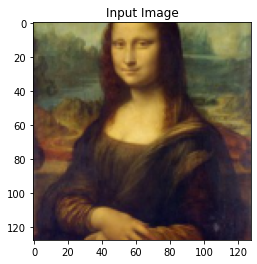

TypeError: ignored

In [33]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = Stogov()